In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 20 14:09:32 2016

@author: Babak Ehteshami Bejnordi

Evaluation code for the Camelyon16 challenge on cancer metastases detecion
"""

import openslide
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as nd
from skimage import measure
import os
import sys
from PIL import Image

   
def computeEvaluationMask(maskDIR, resolution, level):
    """Computes the evaluation mask.
    
    Args:
        maskDIR:    the directory of the ground truth mask
        resolution: Pixel resolution of the image at level 0
        level:      The level at which the evaluation mask is made
        
    Returns:
        evaluation_mask
    """
    slide = openslide.open_slide(maskDIR)
    
    dims = slide.level_dimensions[level]
    
    pixelarray = np.zeros(dims[0]*dims[1], dtype='uint')
    pixelarray = np.array(slide.read_region((0,0), level, dims))

    distance = nd.distance_transform_edt(255 - pixelarray[:,:,0])
    #print(np.unique(distance))
    Threshold = 75/(resolution * pow(2, level) * 2) # 75µm is the equivalent size of 5 tumor cells
    binary = distance < Threshold
    #print(binary)
    filled_image = nd.morphology.binary_fill_holes(binary)
    evaluation_mask = measure.label(filled_image, connectivity = 2) 
    #print(np.unique(evaluation_mask))
    #evaluation_mask = np.array(evaluation_mask)
    vis = evaluation_mask*255/np.max(evaluation_mask)
    print(np.unique(vis))
    im = Image.fromarray(vis)
    plt.figure()
    plt.imshow(im, cmap='gray', vmin=0, vmax=255) 
    plt.show() 
    return evaluation_mask
    
    
def computeITCList(evaluation_mask, resolution, level):
    """Compute the list of labels containing Isolated Tumor Cells (ITC)
    
    Description:
        A region is considered ITC if its longest diameter is below 200µm.
        As we expanded the annotations by 75µm, the major axis of the object 
        should be less than 275µm to be considered as ITC (Each pixel is 
        0.243µm*0.243µm in level 0). Therefore the major axis of the object 
        in level 5 should be less than 275/(2^5*0.243) = 35.36 pixels.
        
    Args:
        evaluation_mask:    The evaluation mask
        resolution:         Pixel resolution of the image at level 0
        level:              The level at which the evaluation mask was made
        
    Returns:
        Isolated_Tumor_Cells: list of labels containing Isolated Tumor Cells
    """
    max_label = np.amax(evaluation_mask)    
    properties = measure.regionprops(evaluation_mask)
    Isolated_Tumor_Cells = [] 
    threshold = 275/(resolution * pow(2, level))
    for i in range(0, max_label):
        if properties[i].major_axis_length < threshold:
            Isolated_Tumor_Cells.append(i+1)
    return Isolated_Tumor_Cells


def readCSVContent(csvDIR):
    """Reads the data inside CSV file
    
    Args:
        csvDIR:    The directory including all the .csv files containing the results.
        Note that the CSV files should have the same name as the original image
        
    Returns:
        Probs:      list of the Probabilities of the detected lesions
        Xcorr:      list of X-coordinates of the lesions
        Ycorr:      list of Y-coordinates of the lesions
    """
    Xcorr, Ycorr, Probs = ([] for i in range(3))
    csv_lines = open(csvDIR,"r").readlines()
    for i in range(len(csv_lines)):
        line = csv_lines[i]
        elems = line.rstrip().split(',')
        Probs.append(float(elems[0]))
        Xcorr.append(int(elems[1]))
        Ycorr.append(int(elems[2]))
    return Probs, Xcorr, Ycorr

def readMaskContent(maskDir, w, h):
    """Reads the data inside CSV file
    
    Args:
        csvDIR:    The directory including all the .csv files containing the results.
        Note that the CSV files should have the same name as the original image
        
    Returns:
        Probs:      list of the Probabilities of the detected lesions
        Xcorr:      list of X-coordinates of the lesions
        Ycorr:      list of Y-coordinates of the lesions
    """
    Xcorr, Ycorr, Probs = ([] for i in range(3))
    predict = Image.open(maskDir).convert('L')
    #print(np.shape(predict))
    predict = predict.resize((w,h))
    predict = np.array(predict)
    predict = predict/np.max(predict)
    #print(np.shape(predict))
    for i in range(len(predict)):
        for j in range(len(predict[0])):
            if predict[i][j] > 0:
                Probs.append(float(predict[i][j]))
                Xcorr.append(int(j))
                Ycorr.append(int(i))

    return Probs, Xcorr, Ycorr
    
         
def compute_FP_TP_Probs(Ycorr, Xcorr, Probs, is_tumor, evaluation_mask, Isolated_Tumor_Cells, level):
    """Generates true positive and false positive stats for the analyzed image
    
    Args:
        Probs:      list of the Probabilities of the detected lesions
        Xcorr:      list of X-coordinates of the lesions
        Ycorr:      list of Y-coordinates of the lesions
        is_tumor:   A boolean variable which is one when the case cotains tumor
        evaluation_mask:    The evaluation mask
        Isolated_Tumor_Cells: list of labels containing Isolated Tumor Cells
        level:      The level at which the evaluation mask was made
         
    Returns:
        FP_probs:   A list containing the probabilities of the false positive detections
        
        TP_probs:   A list containing the probabilities of the True positive detections
        
        NumberOfTumors: Number of Tumors in the image (excluding Isolate Tumor Cells)
        
        detection_summary:   A python dictionary object with keys that are the labels 
        of the lesions that should be detected (non-ITC tumors) and values
        that contain detection details [confidence score, X-coordinate, Y-coordinate]. 
        Lesions that are missed by the algorithm have an empty value.
        
        FP_summary:   A python dictionary object with keys that represent the 
        false positive finding number and values that contain detection 
        details [confidence score, X-coordinate, Y-coordinate]. 
    """

    max_label = np.amax(evaluation_mask)
    FP_probs = [] 
    TP_probs = np.zeros((max_label,), dtype=np.float32)
    detection_summary = {}  
    FP_summary = {}
    for i in range(1,max_label+1):
        if i not in Isolated_Tumor_Cells:
            label = 'Label ' + str(i)
            detection_summary[label] = []        
     
    FP_counter = 0       
    if (is_tumor):
        for i in range(0,len(Xcorr)):
            #print(Ycorr[i])
            #print(Xcorr[i])
            HittedLabel = evaluation_mask[Ycorr[i], Xcorr[i]]
            if HittedLabel == 0:
                FP_probs.append(Probs[i])
                key = 'FP ' + str(FP_counter)
                FP_summary[key] = [Probs[i], Xcorr[i], Ycorr[i]]
                FP_counter+=1
            elif HittedLabel not in Isolated_Tumor_Cells:
                if (Probs[i]>TP_probs[HittedLabel-1]):
                    label = 'Label ' + str(HittedLabel)
                    detection_summary[label] = [Probs[i], Xcorr[i], Ycorr[i]]
                    TP_probs[HittedLabel-1] = Probs[i]                                     
    else:
        for i in range(0,len(Xcorr)):
            FP_probs.append(Probs[i]) 
            key = 'FP ' + str(FP_counter)
            FP_summary[key] = [Probs[i], Xcorr[i], Ycorr[i]] 
            FP_counter+=1
            
    num_of_tumors = max_label - len(Isolated_Tumor_Cells);                             
    return FP_probs, TP_probs, num_of_tumors, detection_summary, FP_summary
 
 
def computeFROC(FROC_data):
    """Generates the data required for plotting the FROC curve
    
    Args:
        FROC_data:      Contains the list of TPs, FPs, number of tumors in each image
         
    Returns:
        total_FPs:      A list containing the average number of false positives
        per image for different thresholds
        
        total_sensitivity:  A list containig overall sensitivity of the system
        for different thresholds
    """
    
    unlisted_FPs = [item for sublist in FROC_data[1] for item in sublist]
    unlisted_TPs = [item for sublist in FROC_data[2] for item in sublist] 
    
    total_FPs, total_TPs = [], []
    all_probs = sorted(set(unlisted_FPs + unlisted_TPs))
    for Thresh in all_probs[1:]:
        total_FPs.append((np.asarray(unlisted_FPs) >= Thresh).sum())
        total_TPs.append((np.asarray(unlisted_TPs) >= Thresh).sum())    
    total_FPs.append(0)
    total_TPs.append(0)
    total_FPs = np.asarray(total_FPs)/float(len(FROC_data[0]))
    total_sensitivity = np.asarray(total_TPs)/float(sum(FROC_data[3]))      
    return  total_FPs, total_sensitivity
   
   
def plotFROC(total_FPs, total_sensitivity):
    """Plots the FROC curve
    
    Args:
        total_FPs:      A list containing the average number of false positives
        per image for different thresholds
        
        total_sensitivity:  A list containig overall sensitivity of the system
        for different thresholds
         
    Returns:
        -
    """    
    fig = plt.figure()
    plt.xlabel('Average Number of False Positives', fontsize=12)
    plt.ylabel('Metastasis detection sensitivity', fontsize=12)  
    fig.suptitle('Free response receiver operating characteristic curve', fontsize=12)
    plt.plot(total_FPs, total_sensitivity, '-', color='#000000')    
    plt.show()       


/tmp/ipykernel_20135/3371830982.py:43: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  filled_image = nd.morphology.binary_fill_holes(binary)


[  0.          36.42857143  72.85714286 109.28571429 145.71428571
 182.14285714 218.57142857 255.        ]


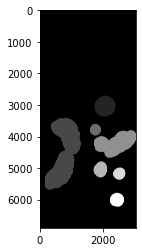

In [28]:
mask_folder = "/data3/ian/dsmil-wsi/test-c16/mask"
maskDIR = "/data3/ian/dsmil-wsi/test-c16/mask/tumor_026_evaluation_mask.png"
EVALUATION_MASK_LEVEL = 5 # Image level at which the evaluation is done
L0_RESOLUTION = 0.243 # pixel resolution at level 0

evaluation_mask = computeEvaluationMask(maskDIR, L0_RESOLUTION,0)
#print(evaluation_mask)
#print(np.unique(evaluation_mask))
h, w = np.shape(evaluation_mask)
maskDir = "/data3/ian/dsmil-wsi/test-c16/tumor_output/tumor_026.png"

Probs, Xcorr, Ycorr = readMaskContent(maskDir, w, h)

Evaluating Performance on image: tumor_044


/tmp/ipykernel_48435/350917990.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  FROC_data = np.zeros((4, len(result_file_list)), dtype=np.object)
/tmp/ipykernel_48435/350917990.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  FP_summary = np.zeros((2, len(result_file_list)), dtype=np.object)
/tmp/ipykernel_48435/350917990.py:11: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this 

[  0. 255.]


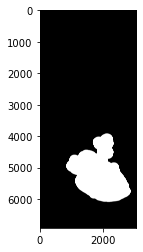

Evaluating Performance on image: tumor_110
[  0. 255.]


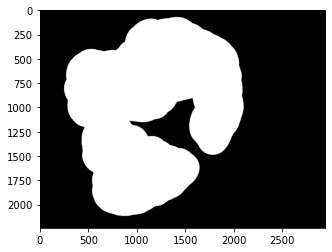

Evaluating Performance on image: tumor_089
[  0. 255.]


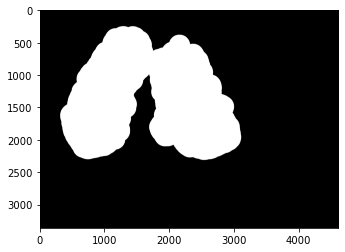

Evaluating Performance on image: tumor_026
[  0.          36.42857143  72.85714286 109.28571429 145.71428571
 182.14285714 218.57142857 255.        ]


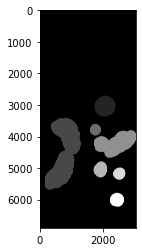

Evaluating Performance on image: tumor_076
[  0.  127.5 255. ]


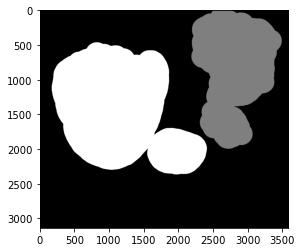

In [ ]:
mask_folder = "/data3/ian/dsmil-wsi/test-c16/eval_mask"
result_folder = "/data3/ian/dsmil-wsi/test-c16/tumor_output"
result_file_list = []
result_file_list += [each[:-20] + '.png' for each in os.listdir(mask_folder)]

EVALUATION_MASK_LEVEL = 0 # Image level at which the evaluation is done
L0_RESOLUTION = 0.243 # pixel resolution at level 0

FROC_data = np.zeros((4, len(result_file_list)), dtype=np.object)
FP_summary = np.zeros((2, len(result_file_list)), dtype=np.object)
detection_summary = np.zeros((2, len(result_file_list)), dtype=np.object)

caseNum = 0    
for case in result_file_list:
    print('Evaluating Performance on image:', case[0:-4])
    sys.stdout.flush()

    is_tumor = case[0:5] == 'tumor'    
    #print(is_tumor)

    if (is_tumor):
        maskDIR = os.path.join(mask_folder, case[0:-4]) + '_evaluation_mask.png'
        evaluation_mask = computeEvaluationMask(maskDIR, L0_RESOLUTION, EVALUATION_MASK_LEVEL)
        ITC_labels = computeITCList(evaluation_mask, L0_RESOLUTION, EVALUATION_MASK_LEVEL)
    else:
        evaluation_mask = 0
        ITC_labels = []
        
    h, w = np.shape(evaluation_mask)
    predict_mask = os.path.join(result_folder, case)
    Probs, Xcorr, Ycorr = readMaskContent(predict_mask, w, h)

    FROC_data[0][caseNum] = case
    FP_summary[0][caseNum] = case
    detection_summary[0][caseNum] = case
    FROC_data[1][caseNum], FROC_data[2][caseNum], FROC_data[3][caseNum], detection_summary[1][caseNum], FP_summary[1][caseNum] = compute_FP_TP_Probs(Ycorr, Xcorr, Probs, is_tumor, evaluation_mask, ITC_labels, EVALUATION_MASK_LEVEL)
    caseNum += 1

# Compute FROC curve 
total_FPs, total_sensitivity = computeFROC(FROC_data)

# plot FROC curve
plotFROC(total_FPs, total_sensitivity)

In [108]:
print(total_FPs)

[1.7753586e+06 1.7751122e+06 1.7677508e+06 1.7629644e+06 1.7599180e+06
 1.7580492e+06 1.7572318e+06 1.7504838e+06 1.7435630e+06 1.7402818e+06
 1.7368976e+06 1.7356712e+06 1.7283808e+06 1.7221896e+06 1.7181558e+06
 1.7155548e+06 1.7140090e+06 1.7068948e+06 1.7011294e+06 1.6962716e+06
 1.6911054e+06 1.6906934e+06 1.6852278e+06 1.6816188e+06 1.6790710e+06
 1.6739026e+06 1.6728998e+06 1.6694140e+06 1.6632006e+06 1.6601448e+06
 1.6530276e+06 1.6504504e+06 1.6479626e+06 1.6377750e+06 1.6323644e+06
 1.6188900e+06 1.6151994e+06 1.6116206e+06 1.5970224e+06 1.5932526e+06
 1.5829422e+06 1.5792206e+06 1.5770640e+06 1.5625544e+06 1.5588382e+06
 1.5455652e+06 1.5393982e+06 1.5353244e+06 1.5081288e+06 1.5037956e+06
 1.4851652e+06 1.4799696e+06 1.4770974e+06 1.4550854e+06 1.4519000e+06
 1.4372818e+06 1.4316828e+06 1.4298392e+06 1.4041338e+06 1.4002318e+06
 1.3922882e+06 1.3761794e+06 1.3739180e+06 1.3425678e+06 1.3382556e+06
 1.3311350e+06 1.3113274e+06 1.3088060e+06 1.2876474e+06 1.2849246e+06
 1.280

In [84]:
print(total_sensitivity)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

In [126]:
FPs = [0.25, 0.5, 1, 2, 4, 8]
sensitivity = [0.17857142857142855,0.3571428571428571,0.5714285714285714,0.5714285714285714,0.5714285714285714,0.7142857142857143]

In [127]:
print(sum(sensitivity)/len(sensitivity))

0.49404761904761907


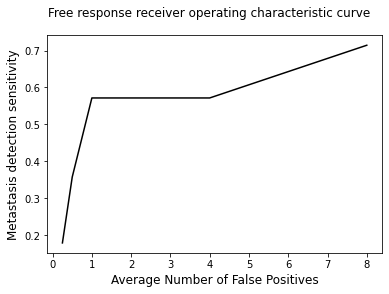

In [128]:
plotFROC(FPs, sensitivity)